## 1. Gathering the data

### 1.1. Get twitter archive from csv

In [17]:
import pandas as pd

In [18]:
twitter_archive = pd.read_csv('data/twitter-archive-enhanced.csv')

In [243]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 1.2. Get image predictions from url

**Instructuion:** The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [242]:
import requests

In [20]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open('data/image-predictions.tsv', 'wb') as f:
    f.write(response.content)
    
image_predictions = pd.read_csv('data/image-predictions.tsv',sep='\t')

In [241]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 1.3. Get extra information using Tweepy

To avoid sharing the keys, I stored them in a config.yaml file (which is ignored by git via .gitignore)

**Instruction:** Gather each tweet's retweet count and favorite (i.e. "like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. 


**Comment:** I think it is a bit weird that we have to store **the entire set of JSON data** for each tweet since we do not use it later. I would rather only store the elements we use (tweet ID, retweet count, and favorite count). If we really want the whole json per tweet (I am not sure why though), I would store each tweet information in a separate file in a json format (since json output per tweet varies quite a bit).

Anyway, I was following the instructions (as I understood them) and find the solution quite dirty: I used all possible json top-level keys as columns and the corresponding values as strings (which were sometimes dictionaries, which I forced into a string format)

In [22]:
import tweepy
import ruamel.yaml as yaml
import os

In [138]:
config = yaml.load(open('keys/config.yaml','rb'), Loader=yaml.Loader)['tweepy']

consumer_key    = config['consumer_key'] 
consumer_secret = config['consumer_secret'] 
access_key      = config['access_key'] 
access_secret   = config['access_secret'] 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [167]:
processed_tweets=0
tweet_json=[]
tweet_ids=twitter_archive.tweet_id.unique().tolist()

for i in tweet_ids:
    tweet = api.statuses_lookup([i])
    tweet_json.append(tweet)
    processed_tweets += 1
    if (processed_tweets % 100 == 0):
        print("%.1f%% of tweets processed" % (100.0*len(processed_tweets)/len(tweet_ids)))

4.2% of tweets processed
8.5% of tweets processed
12.7% of tweets processed
17.0% of tweets processed
21.2% of tweets processed
25.5% of tweets processed
29.7% of tweets processed
34.0% of tweets processed
Rate limit reached. Sleeping for: 125
38.2% of tweets processed
42.4% of tweets processed
46.7% of tweets processed
50.9% of tweets processed
55.2% of tweets processed
59.4% of tweets processed
63.7% of tweets processed
67.9% of tweets processed
72.2% of tweets processed
Rate limit reached. Sleeping for: 607
76.4% of tweets processed
80.6% of tweets processed
84.9% of tweets processed
89.1% of tweets processed
93.4% of tweets processed
97.6% of tweets processed


### A bit vizualisation that helps to store the data correctly
Let´s take a look at the structure of output (how many top-level json keys are there per tweet, which different json keys occur there. This will help to store the data into a well-readable txt

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [204]:
num_keys=[]
json_keys = []
for i in range(len(tweet_json)):
    if len(tweet_json[i])==0:
        num_keys.append(0)
    else:
        keys = list(tweet_json[i][0]._json.keys())
        num_keys.append(len(keys))
        json_keys += keys
        
json_keys=list(set(json_keys)) ##important to have it ordered for later

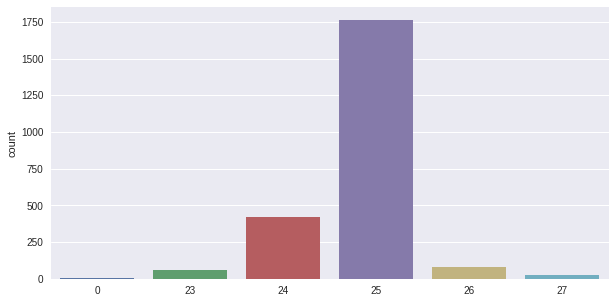

In [408]:
plt.figure(figsize=(10,5))
sns.countplot(num_keys)

In [197]:
sum([1  if x==0 else 0 for x in num_keys ])

6

In [205]:
len(json_keys)

29

Looks like there are either 23,24,25,26 or 27 different json top-level keys with 29 different possible values. Important to take that into consideration before storing the data in txt format.

Note: There were 6 tweet id´s which I was not able to find the information about using Twitter API.

In [317]:
processed_tweets = 0

if os.path.exists("data/tweet_json.txt"):
    os.remove("data/tweet_json.txt")

file = open("data/tweet_json.txt","a")

for tweet in tweet_json:
    ## ignore tweet id's with no information
    if len(tweet)==0:
        pass
    ## write data with \t as a separator; avoid problems by removing \t and \n from the string
    else:
        if processed_tweets > 0:        
            file.write("\n"+'\t'.join([str(tweet[0]._json.get(i)).replace('\t',' ').replace('\n',' ')
                                        for i in json_keys]))
        else:
            file.write('\t'.join(list(json_keys))+
            "\n"+'\t'.join([str(tweet[0]._json.get(i)).replace('\t',' ').replace('\n',' ') for i in json_keys]))
    processed_tweets += 1
file.close()

In [318]:
twitter_extra = pd.read_csv('data/tweet_json.txt',sep='\t')

In [320]:
twitter_extra.head()

,favorited,id,quoted_status_id,coordinates,quoted_status,truncated,id_str,text,in_reply_to_status_id,retweeted_status,...,lang,contributors,possibly_sensitive,place,retweet_count,extended_entities,entities,source,geo,is_quote_status
0,False,892420643555336193,None,None,None,False,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,None,None,...,en,None,False,None,8795,"{'media': [{'id_str': '892420639486877696', 'i...","{'user_mentions': [], 'urls': [], 'media': [{'...","<a href=""http://twitter.com/download/iphone"" r...",None,False
1,False,892177421306343426,None,None,None,True,892177421306343426,This is Tilly. She's just checking pup on you....,None,None,...,en,None,False,None,6449,None,"{'user_mentions': [], 'urls': [{'url': 'https:...","<a href=""http://twitter.com/download/iphone"" r...",None,False
2,False,891815181378084864,None,None,None,True,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,None,None,...,en,None,False,None,4274,None,"{'user_mentions': [], 'urls': [{'url': 'https:...","<a href=""http://twitter.com/download/iphone"" r...",None,False
3,False,891689557279858688,None,None,None,False,891689557279858688,This is Darla. She commenced a snooze mid meal...,None,None,...,en,None,False,None,8884,"{'media': [{'id_str': '891689552724799489', 'i...","{'user_mentions': [], 'urls': [], 'media': [{'...","<a href=""http://twitter.com/download/iphone"" r...",None,False
4,False,891327558926688256,None,None,None,True,891327558926688256,This is Franklin. He would like you to stop ca...,None,None,...,en,None,False,None,9670,None,"{'user_mentions': [], 'urls': [{'url': 'https:...","<a href=""http://twitter.com/download/iphone"" r...",None,False


In [321]:
## take only needed columns
twitter_extra = twitter_extra[['id','retweet_count','favorite_count']]

In [322]:
twitter_extra.head()

,id,retweet_count,favorite_count
0,892420643555336193,8795,39372
1,892177421306343426,6449,33695
2,891815181378084864,4274,25391
3,891689557279858688,8884,42740
4,891327558926688256,9670,40896


## 2. Assessing the data

### Key points to keep in mind when data wrangling for this project:

- We only want original ratings (no retweets) that have images.
- Fully assessing and cleaning the entire dataset requires exceptional effort so only a subset of its issues (eight (8) quality issues and two (2) tidiness issues at minimum) need to be assessed and cleaned.
- Cleaning includes merging individual pieces of data according to the rules of tidy data.

### Implement data quality checks:

1. Is tweet_id unique in each of the dataframes?
2. Check whether twitter_archive dataset contains retweets (in_reply_to_status_id is not null)
3. Check whether all dataframes contain the same number of tweet_id's
4. Check for which tweets the image is not available
5. Check whether name of the dog is extrated correctly in twitter_archive dataframe
6. Check whether rating_numerator & rating_denominator are extrated correctly in twitter_archive dataframe
7. Check how doggo/floofer/pupper/puppo columns are formed in twitter_archive dataframe; can a dog be at the same time both doggo and floofer (or another combination)?

### Check 2.1.
**Question:** Is tweet_id unique in each of the dataframes?

**Conclusion:** no dataframe contains multiple records per tweet id

In [323]:
print(len(twitter_archive)==len(twitter_archive.tweet_id.unique()))
print(len(twitter_extra)==len(twitter_extra.id.unique()))
print(len(image_predictions)==len(image_predictions.tweet_id.unique()))

True
True
True


### Check 2.2.
**Question:** Check whether twitter_archive dataset contains retweets (where any of retweet-related columns is not null)

**Conclusion:** twitter_archive contains 259 retweets

In [444]:
len(twitter_archive[(~pd.isnull(twitter_archive.in_reply_to_status_id)) | \
                    (~pd.isnull(twitter_archive.in_reply_to_user_id)) | \
                    (~pd.isnull(twitter_archive.retweeted_status_id)) | \
                    (~pd.isnull(twitter_archive.retweeted_status_user_id)) | \
                    (~pd.isnull(twitter_archive.retweeted_status_timestamp))]) 

259

### Check 2.3.
**Question:** Check whether all dataframes contain the same number of tweet_id's

**Conclusion:** It is not the case. Twitter_archive has the most tweet id´s. Twitter_extra (extracted using Twitter API) contains less (we could not find information for 6 tweets). Image_predictions does not have predictions for 281 tweets.

In [325]:
print(len(twitter_archive))
print(len(twitter_extra))
print(len(image_predictions))

2356
2350
2075


### Check 2.4.
**Question:** Check for which tweets the image is not available

**Conclusion:**  Images are not available for 281 tweets

In [327]:
tweets_without_images = set(twitter_archive.tweet_id) - set(image_predictions.tweet_id)
print('Images are not available for %d tweets' %len(tweets_without_images))

Images are not available for 281 tweets


In [376]:
image_predictions[pd.isnull(image_predictions.jpg_url)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Check 2.5.
**Question:** Check whether name of the dog is extrated correctly in twitter_archive dataframe

**Conclusion:**  Extracting names seems to be an issue, as I have expected:
- It seems to be extracted as the word following 'Meet' or 'This is', sometimes it is 'a', or 'such'. Doing it right is quite complicated; but could be improved (by at least removing stop words like 'an'/'a'/'such'/'quite'/'the')
- Some present names are missing. For example, names are not returned if it follows 'his name is'
- If name is not present, it is stored as string 'None', much better if it is an empty string

In [377]:
## Couple of examples here:
print ('Text: %s; \nExtracted name: %s' %(twitter_archive.text[22],twitter_archive.name[22]))
print ('\nText: %s; \nExtracted name: %s' %(twitter_archive.text[2335],twitter_archive.name[2335]))
print ('\nText: %s; \nExtracted name: %s' %(twitter_archive.text[2326],twitter_archive.name[2326]))
print ('\nText: %s; \nExtracted name: %s' %(twitter_archive.text[2345],twitter_archive.name[2345]))

print ('\nText: %s; \nExtracted name: %s' %(twitter_archive.text[35],twitter_archive.name[35]))


Text: I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba; 
Extracted name: such

Text: This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv; 
Extracted name: an

Text: This is quite the dog. Gets really excited when not in water. Not very soft tho. Bad at fetch. Can't do tricks. 2/10 https://t.co/aMCTNWO94t; 
Extracted name: quite

Text: This is the happiest dog you will ever see. Very committed owner. Nice couch. 10/10 https://t.co/RhUEAloehK; 
Extracted name: the

Text: I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk; 
Extracted name: None


### Check 2.6.
**Question:** Check whether rating_numerator & rating_denominator are extrated correctly in twitter_archive dataframe

**Conclusion:** Looks like rating numerator and denominator are defined as the first occuring couple number/number in the text. It is not always like that. Not so many examples with multiple occuring couples number/number -> can be cleaned by hand if necessary

In [378]:
## An examples here where it goes wrong (should be 9/10):
print ('Text: %s; \nNumerator: %d, \nDenominator: %d' %(twitter_archive.text[2335],
                                                         twitter_archive.rating_numerator[2335],
                                                         twitter_archive.rating_denominator[2335]))

## Handy to check all possible values of numerator and take a look at weird examples
## Turns out, people sometimes give weird values.
print ('\nText: %s; \nNumerator: %d, \nDenominator: %d' %(twitter_archive.text[1120],
                                                         twitter_archive.rating_numerator[1120],
                                                         twitter_archive.rating_denominator[1120]))

Text: This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv; 
Numerator: 1, 
Denominator: 2

Text: Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv; 
Numerator: 204, 
Denominator: 170


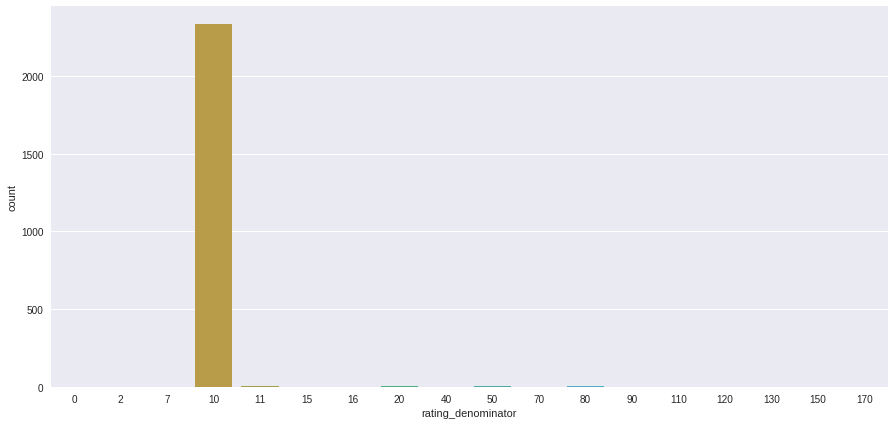

In [414]:
plt.figure(figsize=(15,7))
sns.countplot(twitter_archive.rating_denominator)

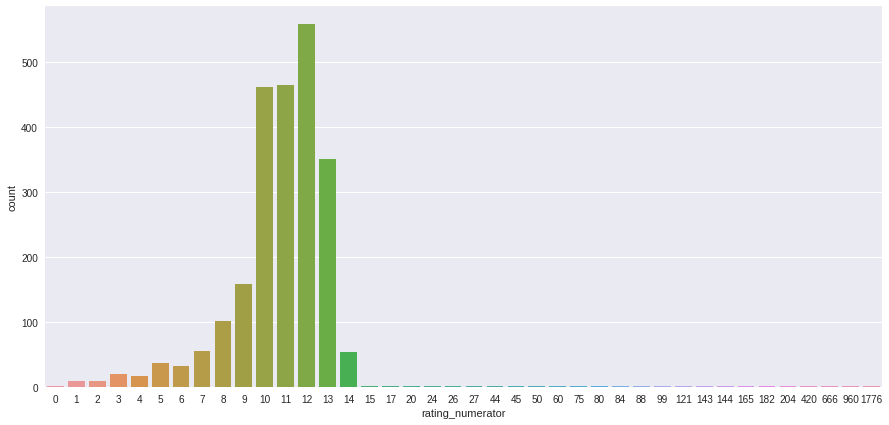

In [412]:
plt.figure(figsize=(15,7))
sns.countplot(twitter_archive.rating_numerator)

### Check 2.7.
**Question:** Check how doggo/floofer/pupper/puppo columns are formed in twitter_archive dataframe; can a dog be at the same time both doggo and floofer (or another combination)?

**Conclusion:** I am not an expert (and not a dog fan either, more a cat person :-)), but it seems to me that doggo/floofer/pupper/puppo are mutually exclusive (since it is a notion of how grown-up a dog is). Got some insights here: https://www.youtube.com/watch?v=ah6fmNEtXFI.

It is then weird that a dog can be both puppo & doggo at the same time -> clearly some information extraction issues. There are also synonyms of puppo (like pup), which are being ignored (hard to solve though, maybe pretrained word2vec can help). If value is not present, it should be empty, not string 'None'

Tidiness issue: better to put stages in one column instead of 4 columns (because 4 columns actually represent one variable). 

In [388]:
twitter_archive.text[191]

"Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel"

In [389]:
twitter_archive.text[200]

"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk"

### Found issues

#### Data quality issues:
1. twitter_archive dataframe contains 259 retweets
2. Dogs names in twitter_archive dataframe contain stopwords like 'an'/'a'/'such'/'quite'/'the')
3. Dogs names in twitter_archive dataframe are missing when could be extracted
4. Dogs names in twitter_archive dataframe are stored as string 'None' if missing instead of Python None
5. Rating numerator and denominator in twitter_archive dataframe are not always extracted correctly
6. The same dog can be assigned to two different stages (puppo/doggo); it looks also more like a dummy variable with 0/1 as possible values
7. If value in columns doggo/floofer/pupper/puppo is not present, it is stored as string 'None' instead of Python None
8. In image_predictions dataframe, prediction can be written in different ways (with capital letter/ lower case)
9. Timestamp in twitter_archive is not stored in datetime format; create separate columns for date & time & week nr for further visualizations
10. Source in twitter_archive is not parsed correctly (still contains html)
11. In image_predictions dataframe, sometimes there is no single prediction per tweet that is dog

#### Data tidiness issues:
Used https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html for details

1. Stages of dog´s growth should be in one column instead of 4 columns (because 4 columns actually represent one variable).
2. image_predictions dataframe should have one prediction per tweet_id -> need to find the way to merge them
3. The same observation is in multiple tables (all collected dataframes should be merged; we will loose some observations in this way)
4. Column xpanded_urls in twitter_archive contains multiple records (comma separated) per observation (see examples under)

In [430]:
twitter_archive.expanded_urls[4]

'https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1'

In [434]:
twitter_archive.expanded_urls[6]

'https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1'

## 3. Cleaning the data

### 3.1. Clean twitter_archive

In [451]:
## remove retweets, keep only useful columns
twitter_archive1 = twitter_archive[~((~pd.isnull(twitter_archive.in_reply_to_status_id)) | \
                    (~pd.isnull(twitter_archive.in_reply_to_user_id)) | \
                    (~pd.isnull(twitter_archive.retweeted_status_id)) | \
                    (~pd.isnull(twitter_archive.retweeted_status_user_id)) | \
                    (~pd.isnull(twitter_archive.retweeted_status_timestamp)))].reset_index(drop=True)\
[['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']]

In [475]:
## fix timestamps:
from datetime import datetime

twitter_archive1["date"] = twitter_archive1["timestamp"].\
apply(lambda x: datetime.date(datetime.strptime(x[0:19],"%Y-%m-%d %H:%M:%S")))
twitter_archive1["time"] = twitter_archive1["timestamp"].\
apply(lambda x: datetime.time(datetime.strptime(x[0:19],"%Y-%m-%d %H:%M:%S")))
twitter_archive1["week_nr"] = twitter_archive1["date"].apply(lambda x: x.isocalendar()[1])

twitter_archive1 = twitter_archive1.drop('timestamp',axis=1)

In [483]:
## fix source:
## dirty solution; but works for this column;
## I found parsers like beautifulsoup an overkill in this case

twitter_archive1["source"] = twitter_archive1["source"].apply(lambda x: x.split('>')[1].split('<')[0])

In [505]:
## fix expanded_urls

def clean_expanded_urls(x):
    if pd.isnull(x):
        return x
    else:
        a = x.split(',')
        return a[len(a)-1]
    
twitter_archive1["expanded_urls"] = twitter_archive1["expanded_urls"].apply(lambda x: clean_expanded_urls(x))

In [530]:
## cleaning names: dirty hack, but removes most of the bad stuff; still not ideal
## One of the possibilities:
## look for all upper case words inside the sentence to see in which setup names occur to add it to the rules
## open names dictionaries typically include too many words

names_to_remove = [x for x in twitter_archive1["name"].unique().tolist() if x.islower()]
twitter_archive1["name"] = twitter_archive1["name"].apply(lambda x: None if x in ['None']+names_to_remove else x)

print(names_to_remove)

['such', 'a', 'quite', 'not', 'one', 'incredibly', 'very', 'my', 'his', 'an', 'actually', 'just', 'getting', 'mad', 'this', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'by', 'officially', 'life', 'light', 'space']


In [547]:
## cleaning numerator&denominator
## doing by hand since not so many examples with multiple ratings-like numbers;
## often there are just 2 ratings (so choosing one is probably ok), but there are couple of clear mistakes
import re
for i in range(len(twitter_archive1)):
    a = re.findall(r'\d+/\d+', twitter_archive1.text[i])
    if len(a)>1:
        print(twitter_archive1.tweet_id[i], '\n'+str(a), '\n'+twitter_archive1.text[i], '\n'+str(twitter_archive1.rating_numerator[i])+'/'+\
              str(twitter_archive1.rating_denominator[i]))

777684233540206592 
['12/10', '11/10'] 
"Yep... just as I suspected. You're not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ 
12/10
747600769478692864 
['10/10', '7/10'] 
This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ 
10/10
740373189193256964 
['9/11', '14/10'] 
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ 
9/11
722974582966214656 
['4/20', '13/10'] 
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a 
4/20
716439118184652801 
['50/50', '11/10'] 
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq 
50/50
714258258790387713 
['10/10', '8/10'] 
Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10
get it together Flurp https://t.co/Akzl5ynMmE 
10/10
70335639378

In [555]:
## clearly examples to fix by hand:
numerator_denominator_dict={740373189193256964:'14/10',
                            722974582966214656:'13/10',
                            716439118184652801:'11/10',
                            666287406224695296:'9/10'}

for i in numerator_denominator_dict:
    twitter_archive1.loc[twitter_archive1['tweet_id'] == i, "rating_numerator"] = \
    int(numerator_denominator_dict[i].split('/')[0])
    twitter_archive1.loc[twitter_archive1['tweet_id'] == i, "rating_denominator"] = \
    int(numerator_denominator_dict[i].split('/')[1])

In [560]:
## dog growth_stage
twitter_archive1['doggo'] = twitter_archive1['doggo'].apply(lambda x: None if x=='None' else x)
twitter_archive1['floofer'] = twitter_archive1['floofer'].apply(lambda x: None if x=='None' else x)
twitter_archive1['pupper'] = twitter_archive1['pupper'].apply(lambda x: None if x=='None' else x)
twitter_archive1['puppo'] = twitter_archive1['puppo'].apply(lambda x: None if x=='None' else x)
twitter_archive1['growth_stage']=twitter_archive1['puppo'].fillna(twitter_archive1['pupper']).\
fillna(twitter_archive1['doggo']).fillna(twitter_archive1['floofer'])

twitter_archive1 = twitter_archive1.drop(['puppo','pupper','floofer','doggo'],axis=1)

In [566]:
twitter_archive1.head()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,date,time,week_nr,growth_stage
0,892420643555336193,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,2017-08-01,16:23:56,31,None
1,892177421306343426,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,2017-08-01,00:17:27,31,None
2,891815181378084864,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,2017-07-31,00:18:03,31,None
3,891689557279858688,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,2017-07-30,15:58:51,30,None
4,891327558926688256,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,2017-07-29,16:00:24,30,None


### 3.2. Clean image_predictions

In [584]:
import numpy as np
## we want to remove all rows where no single prediction is dog
image_predictions1 = image_predictions[~((image_predictions.p1_dog==False) &
                  (image_predictions.p2_dog==False) & 
                  (image_predictions.p3_dog==False))].reset_index(drop=True)

## if prediction is not a dog, change prediction to None
image_predictions1.loc[image_predictions1['p1_dog'] == False, "p1"] = None
image_predictions1.loc[image_predictions1['p2_dog'] == False, "p2"] = None
image_predictions1.loc[image_predictions1['p3_dog'] == False, "p3"] = None

image_predictions1.loc[image_predictions1['p1_dog'] == False, "p1_conf"] = np.nan
image_predictions1.loc[image_predictions1['p2_dog'] == False, "p2_conf"] = np.nan
image_predictions1.loc[image_predictions1['p3_dog'] == False, "p3_conf"] = np.nan

image_predictions1['p'] = image_predictions1['p1'].fillna(image_predictions1['p2']).fillna(image_predictions1['p3'])
image_predictions1['p_conf'] = image_predictions1['p1_conf'].fillna(image_predictions1['p2_conf']).\
fillna(image_predictions1['p3_conf'])

image_predictions1 = image_predictions1.drop(['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'],
                                             axis=1)
## all lowercase
image_predictions1['p'] = image_predictions1['p'].str.lower()

In [585]:
image_predictions1.head()

,tweet_id,jpg_url,img_num,p,p_conf
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311


### 3.3. Clean twitter_extra
- does not need cleaning: took all things into consideration when gathering data
- changing column 'id' in 'tweet_id' to make merge easier

In [587]:
twitter_extra.columns = ['tweet_id','retweet_count','favorite_count']

### 3.4. Merge dataframes

In [589]:
twitter_archive_master = twitter_archive1.merge(image_predictions1).merge(twitter_extra)

In [591]:
twitter_archive_master.head()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,date,time,week_nr,growth_stage,jpg_url,img_num,p,p_conf,retweet_count,favorite_count
0,892177421306343426,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,2017-08-01,00:17:27,31,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,0.323581,6449,33695
1,891815181378084864,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,2017-07-31,00:18:03,31,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,0.716012,4274,25391
2,891689557279858688,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,2017-07-30,15:58:51,30,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,labrador_retriever,0.168086,8884,42740
3,891327558926688256,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,2017-07-29,16:00:24,30,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,9670,40896
4,891087950875897856,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,2017-07-29,00:08:17,30,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,chesapeake_bay_retriever,0.425595,3218,20504


In [590]:
twitter_archive_master.to_csv('data/twitter_archive_master.csv',index=False)

## 4. Investigate dataset

### 4.1. Time series:  how number of tweets, avg amount of retweets & favorite count was developing in time

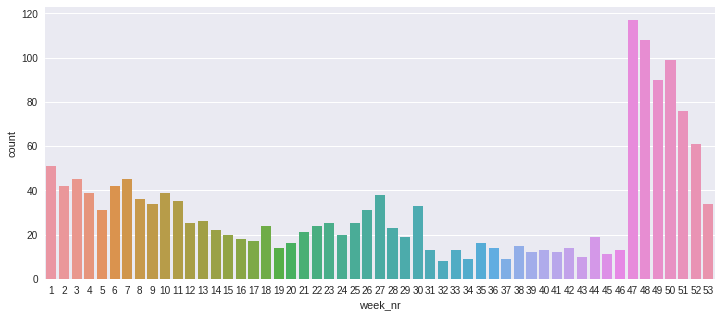

In [651]:
plt.figure(figsize=(12,5))
sns.countplot(twitter_archive_master.week_nr)

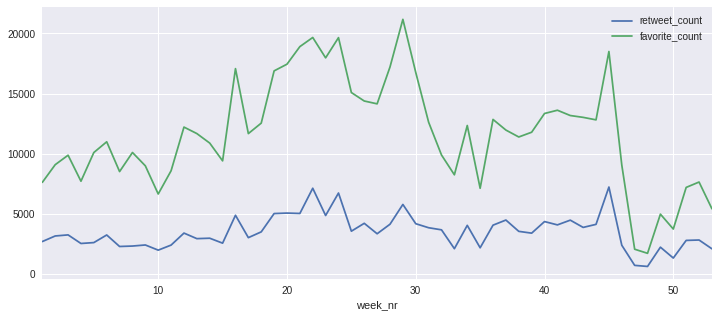

In [652]:
a= twitter_archive_master.groupby('week_nr').agg({'retweet_count':'mean', 
                                               'favorite_count':'mean'}).reset_index()
a.plot(x="week_nr",y=["retweet_count","favorite_count"],figsize=(12,5))

### 4.2. Prediction counts; average retweets per prediction & favorite count; also average confidence, numerator, denominator

In [693]:
b = pd.DataFrame(twitter_archive_master.p.value_counts())
b = b[b.p>15]
most_common_p = dict(zip(b.index,b.p))

a = twitter_archive_master.groupby('p').agg({'retweet_count':'mean', 
                                               'favorite_count':'mean',
                                        'p_conf':'mean',
                                        'rating_numerator':'mean',
                                        'rating_denominator':'mean'}).reset_index()
df = a[a.p.isin(most_common_p)]
df["count"] = df["p"].apply(lambda x: most_common_p[x])

/home/vecht499/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


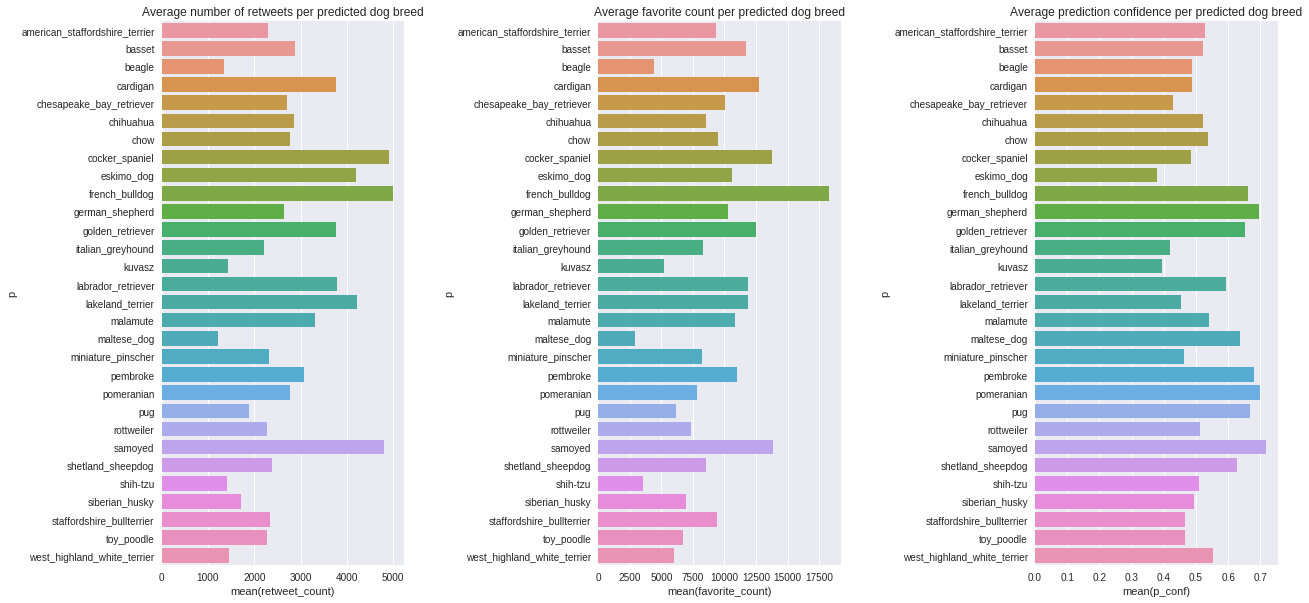

In [678]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.8)

plt.subplot(1,3,1)
sns.barplot(x='retweet_count',y='p', data=df)
plt.title("Average number of retweets per predicted dog breed")

plt.subplot(1,3,2)
sns.barplot(x='favorite_count',y='p', data=df)
plt.title("Average favorite count per predicted dog breed")

plt.subplot(1,3,3)
sns.barplot(x='p_conf',y='p', data=df)
plt.title("Average prediction confidence per predicted dog breed")

plt.show()

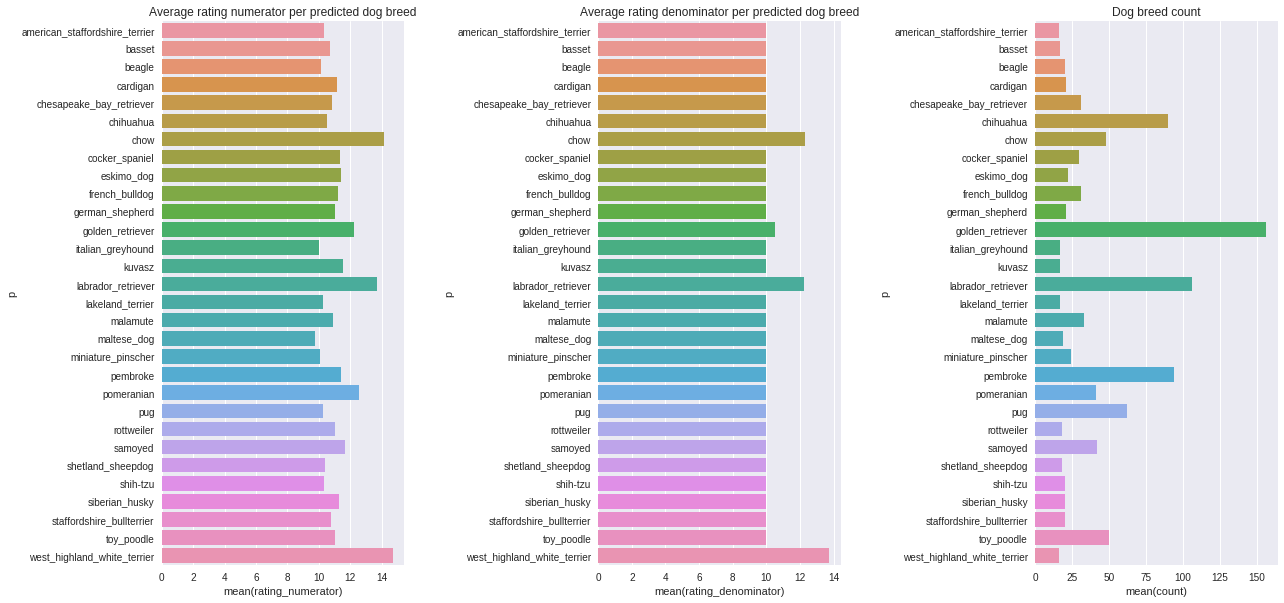

In [692]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.8)

plt.subplot(1,3,1)
sns.barplot(x='rating_numerator',y='p', data=df)
plt.title("Average rating numerator per predicted dog breed")

plt.subplot(1,3,2)
sns.barplot(x='rating_denominator',y='p', data=df)
plt.title("Average rating denominator per predicted dog breed")

plt.subplot(1,3,3)
sns.barplot(x='count',y='p', data=df)
plt.title("Dog breed count")

plt.show()

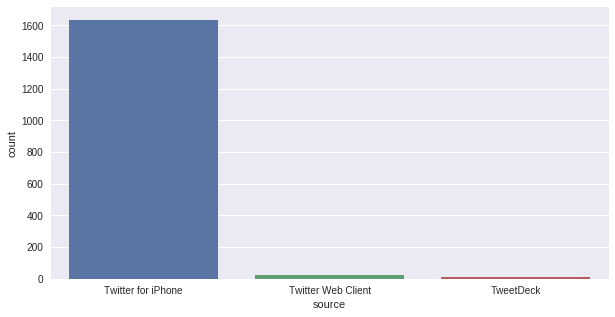

In [607]:
## count per source
plt.figure(figsize=(10,5))
sns.countplot(twitter_archive_master.source)

### Insights:
1. Most users use Twitter for iphone to do the tweets
2. Golden retriever is the most common dog breed (according to the predictions), also breed 'golden retriever' is predicted with high confidence on average.
3. French buldog (which does not occur very often in the tweets) has the highest average favorite count & retweet count.